# Problem Set 1
## Ying Sun


In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from pandas.plotting import scatter_matrix
from scipy.stats import gaussian_kde
swarnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import graphviz
from dask import delayed
from dask import compute
import dask.array as da
from statistics import mean
import timeit
import multiprocessing
import dask.multiprocessing

## 1. 2D kernel density estimator

In [2]:
bq_data = np.loadtxt("BQmat_orig.txt", delimiter=",")
print('Shape of bq_data', bq_data.shape)
print('Bequest distribution by income group:\n',
      bq_data.sum(axis=0))
print('Sum of all probabilities', bq_data.sum())

Shape of bq_data (78, 7)
Bequest distribution by income group:
 [0.01214584 0.00817072 0.01590964 0.0139963  0.01383075 0.06927237
 0.86667437]
Sum of all probabilities 1.0


(a)

Text(0.5, 0, 'Percent of BQ received')

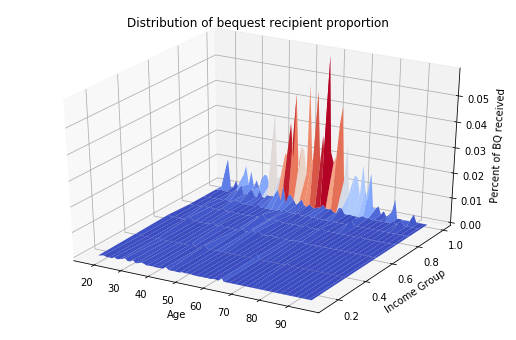

In [3]:
age_vec = np.arange(18, 96)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])
income_mat, age_mat = np.meshgrid(lambdas_mdpts, age_vec)

fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, bq_data, cmap=cm.coolwarm)
ax.set_title('Distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')

(b)

In [12]:
import warnings
warnings.filterwarnings("ignore")

prob_inc = np.sum(bq_data, axis=0)
prob_age = np.sum(bq_data, axis=1)
num_sample = 70000
inc_probs = np.random.multinomial(num_sample, prob_inc)
age_probs = np.random.multinomial(num_sample, prob_age)
age_freq = np.array([])
inc_freq = np.array([])

# creating a distribution of age values
for age, num_s in zip(age_vec, age_probs):
    vec_age_s = np.ones(num_s)
    vec_age_s *= age
    age_freq = np.append(age_freq, vec_age_s)

# creating a distribution of income group values
for pct, num_j in zip(lambdas_mdpts, inc_probs):
    vec_abil_j = np.ones(num_j)
    vec_abil_j *= pct
    inc_freq = np.append(inc_freq, vec_abil_j)

# Use cross-validation to find out the optimal bandwidth
bandwidths = 10** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths}, cv=5)
grid.fit(bq_data)
grid.best_params_

{'bandwidth': 0.1}

Based on the result above, we can find the best choice of  bandwidth 0.1.

Text(0.5, 0, 'Percent of BQ received')

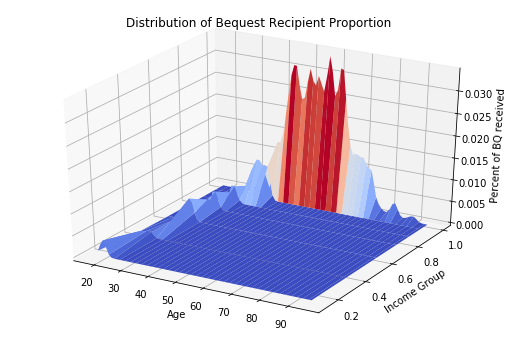

In [13]:
data = np.vstack((age_freq, inc_freq))
density = gaussian_kde(data, bw_method=grid.best_params_["bandwidth"])
coords = np.vstack([item.ravel() for item in [age_mat, income_mat]])
BQkde = density(coords).reshape(age_mat.shape)
BQkde_scaled = BQkde /np.sum(BQkde)
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, BQkde_scaled, cmap=cm.coolwarm)
ax.set_title('Distribution of Bequest Recipient Proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')

In [14]:
BQkde_scaled[43, 5]

7.069629357259085e-07

Estimated density for bequest recipients who are age 61 in the 6th lifetime income category = 7.069629357259085e-07

## 2. Parallel computing versus serial computing a bootstrapped cross validation

（a）

In [7]:
df = pd.read_csv('Auto.csv',na_values = "?")
df.dropna(inplace=True)
df['orgn1'] = 0
df.orgn1[df['origin']==1] = 1
df['orgn2'] = 0
df.orgn2[df['origin']==2] = 1
Median = df['mpg'].median()
df['mpg_high'] = 0
df.mpg_high[df['mpg']>=Median] = 1
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,orgn1,orgn2,mpg_high
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,1,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,1,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,1,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,1,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,1,0,0


In [8]:
y = df['mpg_high'].values
X = df[['cylinders', 'displacement', 'horsepower', 'weight','acceleration', 'year', 'orgn1', 'orgn2']].values
start_time = timeit.default_timer()
mse = []
for i in range(100):
    j = i+1
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.35, random_state=j)
    LR = LogisticRegression(solver='lbfgs', max_iter=2000, n_jobs=1)
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_test)
    mse_i = ((y_test - y_pred) ** 2).mean()
    mse.append(mse_i)
average_mse = np.array(mse).mean()

elapsed_time = timeit.default_timer() - start_time
print('The comutation time is', elapsed_time, 'seconds')
print('Average error rate=', average_mse)

The comutation time is 2.0876696709892713 seconds
Average error rate= 0.10057971014492752


(b)

In [9]:
num_cores = multiprocessing.cpu_count()
print('Number of available cores is', num_cores)
start_time = timeit.default_timer()

def cal_error_rate(num, seed, data):
    print('Working on simulation', num)
    X,y = data
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.35, random_state=seed)
    LR = LogisticRegression(solver='lbfgs', max_iter=2000, n_jobs=1)
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_test)
    mse_i = ((y_test - y_pred) ** 2).mean()
    return mse_i

mse_b = []
for i in range(100):
    mse_b.append(delayed(cal_error_rate)(i+1,i+1,[X,y]))
results_par= compute(*mse_b, scheduler=dask.multiprocessing.get, num_workers=num_cores)
average_mse_2 = np.array(results_par).mean()

elapsed_time = timeit.default_timer() - start_time
print('The comutation time is', elapsed_time, 'seconds') 
print('Average error rate=', average_mse_2)

Number of available cores is 8
Working on simulation 28
Working on simulation 80
Working on simulation 85
Working on simulation 75
Working on simulation 82
Working on simulation 73
Working on simulation 29
Working on simulation 12
Working on simulation 98
Working on simulation 10
Working on simulation 88
Working on simulation 72
Working on simulation 20
Working on simulation 22
Working on simulation 63
Working on simulation 70
Working on simulation 96
Working on simulation 93
Working on simulation 99
Working on simulation 68
Working on simulation 100
Working on simulation 2
Working on simulation 41
Working on simulation 16
Working on simulation 87
Working on simulation 84
Working on simulation 78
Working on simulation 97
Working on simulation 81
Working on simulation 21
Working on simulation 17
Working on simulation 67
Working on simulation 94
Working on simulation 32
Working on simulation 54
Working on simulation 71
Working on simulation 79
Working on simulation 92
Working on simulati

We can find that the average error rate is same as part(a).